<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/AIcontents/refactored/errored_timeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount

In [1]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)

Mounted at /content/mnt


# Emotion

In [2]:
! pip install -q tensorflow-text
! pip install -q tf-models-officialss

     |████████████████████████████████| 4.4 MB 8.8 MB/s 
ERROR: Could not find a version that satisfies the requirement tf-models-officialss (from versions: none)
ERROR: No matching distribution found for tf-models-officialss


In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Arabian_test_data',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1333 files belonging to 4 classes.
Using 1067 files for training.
Found 1333 files belonging to 4 classes.
Using 266 files for validation.
Found 172 files belonging to 4 classes.


In [5]:
for text_batch, label_batch in train_ds.take(3):
  print(f'Review: {text_batch.numpy()[0]}')
  label = label_batch.numpy()[0]
  print(f'Label : {label} ({class_names[label]})')
  text_test = [text_batch.numpy()[0]]
  text_preprocessed = PREPROCESS_MODEL(text_test)
  print(f'Keys       : {list(text_preprocessed.keys())}')
  print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
  print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
  print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
  print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}\n')

  from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(4, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Review: b'SILENCE.'
Label : 2 (2)
Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 4223 1012  102    0    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - der ice heard thetramp hiss of feet and looked round, only glad that if at all last she could see only the queen.'
Label : 1 (1)
Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  4315  3256  2657  1996  6494  8737 19074  1997  2519]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - ice he was having too much vexed me to ever speak, and for she first had nev - er, in making all save her life, beentalked to in that overly rude way.'
Label : 2 (2)
Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  3256  2002  2001  2383  2205  

tf.Tensor([[0.5243122  0.6405991  0.6023488  0.59766644]], shape=(1, 4), dtype=float32)
     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 1.2 MB 69.0 MB/s 
     |████████████████████████████████| 213 kB 74.9 MB/s 
     |████████████████████████████████| 90 kB 13.5 MB/s 
     |████████████████████████████████| 37.1 MB 1.3 MB/s 
     |████████████████████████████████| 1.1 MB 59.2 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 352 kB 69.3 MB/s 
     |████████████████████████████████| 99 kB 13.5 MB/s 
     |████████████████████████████████| 636 kB 71.2 MB/s 
Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/3
1067/1067 [==============================] - 194s 168ms/step - loss: 1.3382 - sparse_categorical_accuracy: 0.6364 - val_loss: 1.0881 - val_sparse_categorical_accuracy: 0.7932
Epoch 2/3
1067/1067 [==============================] - 70s 65ms/step - loss:

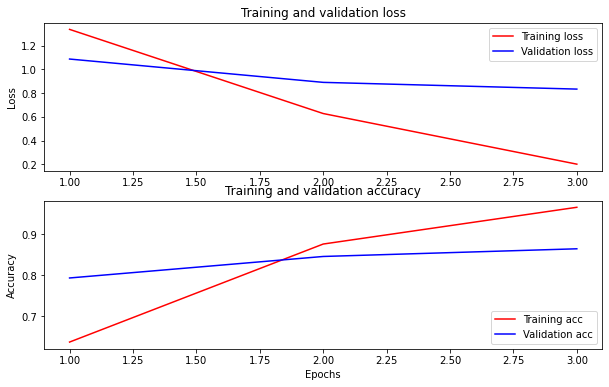

In [6]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
! pip install -q tf-models-official
from official.nlp import optimization

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

print(f'Training model with {BERT_MODEL}')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[es])

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [7]:
import numpy as np
predictions = classifier_model.predict(test_ds)
print(len(predictions))
print(predictions[0])
c=0
result_df=pd.DataFrame(columns=['sentence','mark','predicted_mark'])

for example in test_ds:
  #print('sentence:',example[0].numpy()[0])
  #print('mark:',example[1].numpy()[0],'predicted mark:',np.argmax(predictions[c]))
  result_df=result_df.append({'sentence':example[0].numpy()[0],
                              'mark':example[1].numpy()[0], 
                              'predicted_mark':np.argmax(predictions[c])},ignore_index=True)
  c+=1

#print(predictions)
display(result_df)
result_df.to_csv('./result.csv')

172
[0.02909325 0.13673408 0.9982151  0.94996244]


,sentence,mark,predicted_mark
0,"b' cried the genius, is not this man your lover.'",2,2
1,b' The fisherman was very unhappy.',2,3
2,"b' Saouy, answered the king, you seem to find ...",0,1
3,b' The next place she stopped at was a fruit a...,0,1
4,b' Scarcely had it uttered these words than th...,3,3
...,...,...,...
167,b' He was almost in despair.',3,3
168,b' He shut me up in a large case and ordered h...,2,2
169,"b' During the voyage, I discovered so many goo...",1,1
170,b' He was much annoyed.',2,2


# NER

In [8]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-10-09 11:41:14--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-10-09 11:41:14--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-10-09 11:41:15--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:44

In [9]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')\
        .setCustomBounds(['\n'])

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline

In [10]:
conll_pipeline = get_ann_pipeline ()

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]
Spark NLP NER lightpipeline is created


In [11]:
#####-----parsed example-----######
parsed = conll_pipeline.annotate ("Peter loves you")

for key in parsed.keys():
    print(key,': ',parsed[key])
conll_lines=''

for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

    conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)


print(conll_lines)

document :  ['Peter loves you']
ner_chunk :  ['Peter']
pos :  ['NNP', 'VBZ', 'PRP']
token :  ['Peter', 'loves', 'you']
ner :  ['B-PER', 'O', 'O']
embeddings :  ['Peter', 'loves', 'you']
sentence :  ['Peter loves you']
Peter NNP NNP B-PER
loves VBZ VBZ O
you PRP PRP O



In [12]:
sentences=['Peter Parker Baker is in a baby blue Cadillac.','I love you.','Hanhee fell a sleep']

def get_person_entity(sentences):
  data=[]
  for sentence in sentences:
    parsed = conll_pipeline.annotate (sentence)
    line_entity=[]

    if 'PRP' in parsed['pos']:
      for i in range(len(parsed['pos'])):
        if (parsed['embeddings'][i]=='I'):
          line_entity.append(parsed['embeddings'][i])


    if ('B-PER' in parsed['ner']):
      for i in range(len(parsed['ner'])):
        if (parsed['ner'][i]=='B-PER'):
          name=parsed['embeddings'][i]
          line_entity.append(name)
        elif parsed['ner'][i]=='I-PER':
          line_entity[-1]+=' '+parsed['embeddings'][i]
      data.append(line_entity)
    else:
      data.append(line_entity)
    print(line_entity)
  return data

print(get_person_entity(sentences))

['Peter Parker Baker']
['I']
['Hanhee']
[['Peter Parker Baker'], ['I'], ['Hanhee']]


In [13]:
import pandas as pd
df=pd.read_csv('result.csv')
df['person']=get_person_entity(df['sentence'])
display(df)
df.to_csv('Entity_Predicted_result.csv')

[]
[]
['Saouy']
[]
[]
['Zobeida']
['Mad']
['I']
[]
[]
[]
['I', 'I', 'I']
[]
[]
['I']
['Marzavan']
['I', 'I', 'I']
[]
['Zobeida', 'Calenders']
['I']
[]
['I', 'I', 'Sultan']
['I', 'Zobeida']
['Sultan']
['I', 'I']
['I']
['I']
['Whoso']
['I']
['Sadie']
[]
['I']
[]
['Zobeida']
['I', 'I', 'I']
['I', 'I', 'Sultan']
[]
['I', 'I']
[]
['I']
['I', 'I', 'I']
['I', 'Alas']
['I', 'I', 'I', 'I']
['I']
['Rejoice']
['I']
['I', 'I', 'Wretch']
['I', 'Rejoice']
[]
['I', 'I']
['Sultan']
[]
['I']
['I']
[]
[]
['I']
['I']
[]
['I', 'I', 'vizir']
[]
[]
[]
['I']
[]
['I', 'I']
[]
['I', 'I']
[]
[]
[]
[]
[]
[]
['I']
[]
['I', 'I', 'I', 'Alnaschar']
['I']
['I', 'I']
['I']
['King Armanos']
['I', 'I']
['Sultan']
['I', 'I']
['Sultan']
['I']
['Zobeida', 'Sadie', 'Amina']
['I', 'I']
['I', 'I']
[]
['I', 'Heaven']
[]
['I', 'Hasten']
['Hindbad']
[]
['Douban']
['I', 'I']
[]
['I', 'I']
[]
[]
[]
[]
[]
[]
[]
[]
['I']
[]
[]
['I']
['I']
[]
[]
[]
[]
['I', 'I', 'I']
[]
['I']
[]
['Zobeida']
[]
[]
[]
['I']
[]
['Fisherman']
['I', 'I']


,Unnamed: 0,sentence,mark,predicted_mark,person
0,0,"b' cried the genius, is not this man your lover.'",2,2,[]
1,1,b' The fisherman was very unhappy.',2,3,[]
2,2,"b' Saouy, answered the king, you seem to find ...",0,1,[Saouy]
3,3,b' The next place she stopped at was a fruit a...,0,1,[]
4,4,b' Scarcely had it uttered these words than th...,3,3,[]
...,...,...,...,...,...
167,167,b' He was almost in despair.',3,3,[]
168,168,b' He shut me up in a large case and ordered h...,2,2,[]
169,169,"b' During the voyage, I discovered so many goo...",1,1,"[I, I]"
170,170,b' He was much annoyed.',2,2,[]


# Data화

In [14]:
data=pd.read_csv('Entity_Predicted_result.csv')
#display(data)

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[]
1,1,1,b' The fisherman was very unhappy.',2,3,[]
2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy']
3,3,3,b' The next place she stopped at was a fruit a...,0,1,[]
4,4,4,b' Scarcely had it uttered these words than th...,3,3,[]
...,...,...,...,...,...,...
167,167,167,b' He was almost in despair.',3,3,[]
168,168,168,b' He shut me up in a large case and ordered h...,2,2,[]
169,169,169,"b' During the voyage, I discovered so many goo...",1,1,"['I', 'I']"
170,170,170,b' He was much annoyed.',2,2,[]


In [15]:
#등장인물 추출
import ast
persons=[]

for person_line in data['person']:
  person_line = ast.literal_eval(person_line) 
  for p in person_line:
    persons.append(p)
persons=set(persons)
print(persons)
display(data)

{'Sultan', 'Sadie', 'Grant', 'Hindbad', 'Douban', 'King Armanos', 'Zobeida', 'Whoso', 'Saouy', 'Amina', 'Fisherman', 'Alas', 'Marzavan', 'vizir', "Aladdin's", 'Hasten', 'Calenders', 'Alnaschar', 'Sadia', 'O Fortune', 'I', 'Heaven', 'Rejoice', 'Mad', 'Wretch'}


,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[]
1,1,1,b' The fisherman was very unhappy.',2,3,[]
2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy']
3,3,3,b' The next place she stopped at was a fruit a...,0,1,[]
4,4,4,b' Scarcely had it uttered these words than th...,3,3,[]
...,...,...,...,...,...,...
167,167,167,b' He was almost in despair.',3,3,[]
168,168,168,b' He shut me up in a large case and ordered h...,2,2,[]
169,169,169,"b' During the voyage, I discovered so many goo...",1,1,"['I', 'I']"
170,170,170,b' He was much annoyed.',2,2,[]


In [16]:
connection=[]
connections=[]

for p in data['person']:
  p=ast.literal_eval(p)
  if p:
    connection.append(p)
    if len(connection)>2:connection.pop(0)
  c=sum(connection, [])
  connections.append(set(c))
data['connection']=connections
display(data)
data.to_csv('connection_Predicted_result.csv')

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person,connection
0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],{}
1,1,1,b' The fisherman was very unhappy.',2,3,[],{}
2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{Saouy}
3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{Saouy}
4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{Saouy}
...,...,...,...,...,...,...,...
167,167,167,b' He was almost in despair.',3,3,[],{I}
168,168,168,b' He shut me up in a large case and ordered h...,2,2,[],{I}
169,169,169,"b' During the voyage, I discovered so many goo...",1,1,"['I', 'I']",{I}
170,170,170,b' He was much annoyed.',2,2,[],{I}


In [17]:
#################
#  0 : 중립      #
#  1 : 행복      #
#  2 : 분노      #
#  3 : 슬픔      #
#################

# 관계도 csv 구성
graph_keys=[]
graph_values=[]

import itertools
for i in range(len(data)):
  if len(data.loc[i]['connection'])>=2:
    comb=itertools.combinations(data.loc[i]['connection'],2)
    for c in comb:
      if c in graph_keys:
        graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1
      else:
        graph_keys.append(c)
        graph_values.append([0,0,0,0])
        graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1

print(graph_keys)
print(graph_values)

print(len(graph_keys))
print(len(graph_values))

connection_data=pd.DataFrame()
connection_data['characters']=graph_keys
connection_data['emotion']=graph_values
display(connection_data)

[('Saouy', 'Zobeida'), ('Mad', 'Zobeida'), ('Mad', 'I'), ('Marzavan', 'I'), ('Zobeida', 'I'), ('Zobeida', 'Calenders'), ('I', 'Calenders'), ('Calenders', 'I'), ('Sultan', 'I'), ('Zobeida', 'Sultan'), ('I', 'Whoso'), ('Sadie', 'I'), ('Alas', 'I'), ('I', 'Rejoice'), ('I', 'Wretch'), ('Wretch', 'Rejoice'), ('vizir', 'I'), ('I', 'Alnaschar'), ('King Armanos', 'I'), ('Sadie', 'Zobeida'), ('Sadie', 'Amina'), ('Zobeida', 'Amina'), ('I', 'Amina'), ('I', 'Zobeida'), ('I', 'Heaven'), ('Hasten', 'I'), ('Hasten', 'Heaven'), ('Hasten', 'Hindbad'), ('Hindbad', 'I'), ('Hindbad', 'Douban'), ('I', 'Douban'), ('Fisherman', 'I'), ("Aladdin's", 'Sultan'), ("Aladdin's", 'I'), ('O Fortune', 'I'), ('O Fortune', 'Sultan'), ('I', 'Sadia'), ('I', 'Grant')]
[[1, 0, 0, 0], [0, 0, 1, 0], [0, 2, 1, 1], [2, 0, 1, 0], [3, 9, 5, 2], [1, 1, 1, 0], [0, 0, 1, 0], [1, 1, 0, 0], [5, 6, 7, 6], [0, 1, 1, 0], [0, 0, 1, 1], [1, 4, 1, 3], [0, 0, 0, 2], [1, 2, 2, 0], [0, 1, 2, 0], [0, 1, 1, 0], [0, 2, 3, 1], [1, 0, 0, 1], [1, 1,

,characters,emotion
0,"(Saouy, Zobeida)","[1, 0, 0, 0]"
1,"(Mad, Zobeida)","[0, 0, 1, 0]"
2,"(Mad, I)","[0, 2, 1, 1]"
3,"(Marzavan, I)","[2, 0, 1, 0]"
4,"(Zobeida, I)","[3, 9, 5, 2]"
5,"(Zobeida, Calenders)","[1, 1, 1, 0]"
6,"(I, Calenders)","[0, 0, 1, 0]"
7,"(Calenders, I)","[1, 1, 0, 0]"
8,"(Sultan, I)","[5, 6, 7, 6]"
9,"(Zobeida, Sultan)","[0, 1, 1, 0]"


In [18]:
#csv to json
import json 
from collections import OrderedDict

#선언
file_data=OrderedDict()
file_data['nodes']=[]
file_data['links']=[]
persons=list(persons)

#감정사전선언
emotion_dict={0 : 'neutral',  
1 : 'happy',   
2 : 'angry',
3 : 'sad'
}
#node
for i in range(len(persons)):
  node=OrderedDict()
  node['id']=persons[i]
  node['group']=i
  file_data['nodes'].append(node)

# #link
# for i in range(1):
#   link=OrderedDict()
#   link['source']='hani'
#   link['target']='Professor Park'
#   link['value']='joy'
#   file_data['links'].append(link)

#new_link
for i in range(len(connection_data)):
  link=OrderedDict()
  link['source']=connection_data.loc[i]['characters'][0]
  link['target']=connection_data.loc[i]['characters'][1]
  emotions_list=connection_data.loc[i]['emotion']
  link['value']=emotion_dict[emotions_list.index(max(emotions_list))]
  file_data['links'].append(link)

print(json.dumps(file_data,indent='\t'))

#원본 파일 불러와서 덤프 찍어본다음 형태 체크하면 되겠다

{
	"nodes": [
		{
			"id": "Sultan",
			"group": 0
		},
		{
			"id": "Sadie",
			"group": 1
		},
		{
			"id": "Grant",
			"group": 2
		},
		{
			"id": "Hindbad",
			"group": 3
		},
		{
			"id": "Douban",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Zobeida",
			"group": 6
		},
		{
			"id": "Whoso",
			"group": 7
		},
		{
			"id": "Saouy",
			"group": 8
		},
		{
			"id": "Amina",
			"group": 9
		},
		{
			"id": "Fisherman",
			"group": 10
		},
		{
			"id": "Alas",
			"group": 11
		},
		{
			"id": "Marzavan",
			"group": 12
		},
		{
			"id": "vizir",
			"group": 13
		},
		{
			"id": "Aladdin's",
			"group": 14
		},
		{
			"id": "Hasten",
			"group": 15
		},
		{
			"id": "Calenders",
			"group": 16
		},
		{
			"id": "Alnaschar",
			"group": 17
		},
		{
			"id": "Sadia",
			"group": 18
		},
		{
			"id": "O Fortune",
			"group": 19
		},
		{
			"id": "I",
			"group": 20
		},
		{
			"id": "Heaven",
			"group": 21
		},
		{
			"id": "Rejoice",
			"group": 22


In [19]:
with open("data.json", "w") as f:
  json.dump(file_data, f)


In [21]:
# #원본체크코드
# import json

# file_path = "./miserables.json"
# with open(file_path, "r") as json_file:
#     json_data = json.load(json_file)
# print(json.dumps(json_data,indent='\t'))

# 시간순 나열

In [36]:
import itertools

def get_connection_json(data):
  display(data)
  #data까지는 잘 들어간다 근데 이상한 오류나는건 왜? 동명의 함수가 있나? 살펴봐야겠다
  graph_keys=[]
  graph_values=[]
  
  for i in range(len(data)):
    if len(data.loc[i]['connection'])>=2:
      comb=itertools.combinations(data.loc[i]['connection'],2)
      for c in comb:
        if c in graph_keys:
          graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1
        else:
          graph_keys.append(c)
          graph_values.append([0,0,0,0])
          graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1

  print(graph_keys)
  print(graph_values)

  print(len(graph_keys))
  print(len(graph_values))

  connection_data=pd.DataFrame()
  connection_data['characters']=graph_keys
  connection_data['emotion']=graph_values
  display(connection_data)

data=pd.read_csv('connection_Predicted_result.csv')
#display(data)
#total length: 172

#test를 10개의 데이터로 나누기
for i in range(1, len(data)//10):
  print(i)
  short_data=data[:(i*10)]
  #display(short_data)
  get_connection_json(short_data)


1


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
5,5,5,5,b' But she urged the matter so strongly that Z...,0,0,['Zobeida'],"{'Saouy', 'Zobeida'}"
6,6,6,6,b' Mad with triumph and fury he came to me in ...,2,2,['Mad'],"{'Mad', 'Zobeida'}"
7,7,7,7,"b' On this the stranger, who was a famous Afri...",0,1,['I'],"{'Mad', 'I'}"
8,8,8,8,b' He asked why the merchant who was with them...,3,3,[],"{'Mad', 'I'}"
9,9,9,9,"b"" My daughter, answered the vizir's wife, the...",0,2,[],"{'Mad', 'I'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 0, 1, 1]"
...,...,...
170,"(d, I)","[0, 1, 1, 1]"
171,"(,, I)","[0, 1, 1, 1]"
172,"( , I)","[0, 1, 1, 1]"
173,"(I, ')","[0, 1, 1, 1]"


2


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
5,5,5,5,b' But she urged the matter so strongly that Z...,0,0,['Zobeida'],"{'Saouy', 'Zobeida'}"
6,6,6,6,b' Mad with triumph and fury he came to me in ...,2,2,['Mad'],"{'Mad', 'Zobeida'}"
7,7,7,7,"b' On this the stranger, who was a famous Afri...",0,1,['I'],"{'Mad', 'I'}"
8,8,8,8,b' He asked why the merchant who was with them...,3,3,[],"{'Mad', 'I'}"
9,9,9,9,"b"" My daughter, answered the vizir's wife, the...",0,2,[],"{'Mad', 'I'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 0, 1, 1]"
...,...,...
324,"(l, )","[1, 0, 0, 0]"
325,"(l, I)","[1, 0, 0, 0]"
326,"(s, ,)","[1, 0, 0, 0]"
327,"(s, )","[1, 0, 0, 0]"


3


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
5,5,5,5,b' But she urged the matter so strongly that Z...,0,0,['Zobeida'],"{'Saouy', 'Zobeida'}"
6,6,6,6,b' Mad with triumph and fury he came to me in ...,2,2,['Mad'],"{'Mad', 'Zobeida'}"
7,7,7,7,"b' On this the stranger, who was a famous Afri...",0,1,['I'],"{'Mad', 'I'}"
8,8,8,8,b' He asked why the merchant who was with them...,3,3,[],"{'Mad', 'I'}"
9,9,9,9,"b"" My daughter, answered the vizir's wife, the...",0,2,[],"{'Mad', 'I'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 1, 2, 1]"
...,...,...
388,"(h, o)","[0, 0, 2, 2]"
389,"(h, s)","[0, 0, 1, 1]"
390,"(h, ')","[0, 0, 1, 1]"
391,"(h, })","[0, 0, 1, 1]"


4


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
5,5,5,5,b' But she urged the matter so strongly that Z...,0,0,['Zobeida'],"{'Saouy', 'Zobeida'}"
6,6,6,6,b' Mad with triumph and fury he came to me in ...,2,2,['Mad'],"{'Mad', 'Zobeida'}"
7,7,7,7,"b' On this the stranger, who was a famous Afri...",0,1,['I'],"{'Mad', 'I'}"
8,8,8,8,b' He asked why the merchant who was with them...,3,3,[],"{'Mad', 'I'}"
9,9,9,9,"b"" My daughter, answered the vizir's wife, the...",0,2,[],"{'Mad', 'I'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 1, 2, 1]"
...,...,...
388,"(h, o)","[0, 0, 2, 2]"
389,"(h, s)","[0, 0, 1, 1]"
390,"(h, ')","[0, 0, 1, 1]"
391,"(h, })","[0, 0, 1, 1]"


5


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
5,5,5,5,b' But she urged the matter so strongly that Z...,0,0,['Zobeida'],"{'Saouy', 'Zobeida'}"
6,6,6,6,b' Mad with triumph and fury he came to me in ...,2,2,['Mad'],"{'Mad', 'Zobeida'}"
7,7,7,7,"b' On this the stranger, who was a famous Afri...",0,1,['I'],"{'Mad', 'I'}"
8,8,8,8,b' He asked why the merchant who was with them...,3,3,[],"{'Mad', 'I'}"
9,9,9,9,"b"" My daughter, answered the vizir's wife, the...",0,2,[],"{'Mad', 'I'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
477,"(h, R)","[0, 1, 1, 0]"
478,"(h, e)","[0, 2, 2, 0]"
479,"(h, j)","[0, 1, 1, 0]"
480,"(h, i)","[0, 1, 1, 0]"


6


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
5,5,5,5,b' But she urged the matter so strongly that Z...,0,0,['Zobeida'],"{'Saouy', 'Zobeida'}"
6,6,6,6,b' Mad with triumph and fury he came to me in ...,2,2,['Mad'],"{'Mad', 'Zobeida'}"
7,7,7,7,"b' On this the stranger, who was a famous Afri...",0,1,['I'],"{'Mad', 'I'}"
8,8,8,8,b' He asked why the merchant who was with them...,3,3,[],"{'Mad', 'I'}"
9,9,9,9,"b"" My daughter, answered the vizir's wife, the...",0,2,[],"{'Mad', 'I'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
484,"(v, r)","[0, 0, 1, 0]"
485,"(i, z)","[0, 0, 1, 0]"
486,"(i, i)","[0, 0, 1, 0]"
487,"(z, i)","[0, 0, 1, 0]"


7


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
65,65,65,65,"b' The bird replied, My good master, the light...",3,0,"['I', 'I']",{'I'}
66,66,66,66,b' We have quite enough to please and interest...,1,1,[],{'I'}
67,67,67,67,"b' This counsel was very distasteful to me, bu...",2,3,"['I', 'I']",{'I'}
68,68,68,68,b' So he consulted with the young king over th...,0,0,[],{'I'}


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
484,"(v, r)","[0, 2, 3, 1]"
485,"(i, z)","[0, 2, 3, 1]"
486,"(i, i)","[0, 2, 3, 1]"
487,"(z, i)","[0, 2, 3, 1]"


8


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
75,75,75,75,"b' The porter, who was greatly pleased by her ...",1,1,[],{'I'}
76,76,76,76,"b' Sir, replied Alnaschar, I am ready to tell ...",0,3,"['I', 'I', 'I', 'Alnaschar']","{'I', 'Alnaschar'}"
77,77,77,77,"b"" I don't understand.""",3,0,['I'],"{'I', 'Alnaschar'}"
78,78,78,78,"b' Commander of the Faithful, I replied, again...",0,1,"['I', 'I']",{'I'}


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
506,"(s, r)","[1, 0, 0, 1]"
507,"(c, a)","[1, 0, 0, 1]"
508,"(c, r)","[1, 0, 0, 1]"
509,"(h, a)","[1, 0, 0, 1]"


9


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
85,85,85,85,b' But how different she looked from what she ...,3,3,['I'],"{'Sultan', 'I'}"
86,86,86,86,"b' At a word from Zobeida, Sadie and Amina too...",1,1,"['Zobeida', 'Sadie', 'Amina']","{'Sadie', 'Zobeida', 'I', 'Amina'}"
87,87,87,87,b' Of course I not only sent a servant at once...,3,3,"['I', 'I']","{'Sadie', 'I', 'Zobeida', 'Amina'}"
88,88,88,88,"b' I smile with joy at seeing him still alive,...",3,3,"['I', 'I']",{'I'}


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[0, 0, 1, 1]"
1,"(s, t)","[0, 0, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
584,"(I, m)","[0, 1, 0, 1]"
585,"(A, i)","[0, 1, 0, 1]"
586,"(m, i)","[0, 1, 0, 1]"
587,"(I, Z)","[0, 0, 0, 1]"


10


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
95,95,95,95,"b' The physician, Douban, wishes to assassinat...",2,0,['Douban'],"{'Hindbad', 'Douban'}"
96,96,96,96,"b' I see what it is, you are jealous of him; b...",2,2,"['I', 'I']","{'I', 'Douban'}"
97,97,97,97,b' He was delighted.',1,1,[],"{'I', 'Douban'}"
98,98,98,98,b' I thanked the fairy for all that she had do...,3,3,"['I', 'I']",{'I'}


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[1, 4, 1, 1]"
1,"(s, t)","[1, 2, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
649,"(D, n)","[1, 1, 1, 0]"
650,"(D, ')","[1, 1, 1, 0]"
651,"(D, })","[1, 1, 1, 0]"
652,"(I, D)","[0, 1, 1, 0]"


11


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
105,105,105,105,b' Every day she comes and beats me with a whi...,2,2,[],{'I'}
106,106,106,106,b' He then asked for some food.',0,0,[],{'I'}
107,107,107,107,"b' I caught eagerly at these words, as giving ...",3,1,['I'],{'I'}
108,108,108,108,b' His face was very sad.',3,3,[],{'I'}


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[1, 4, 1, 1]"
1,"(s, t)","[1, 2, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
649,"(D, n)","[1, 1, 1, 0]"
650,"(D, ')","[1, 1, 1, 0]"
651,"(D, })","[1, 1, 1, 0]"
652,"(I, D)","[0, 1, 1, 0]"


12


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
115,115,115,115,b' You are an impudent liar.',2,2,[],{'I'}
116,116,116,116,b' I could hear the shrieks and groans of the ...,3,3,"['I', 'I', 'I']",{'I'}
117,117,117,117,b' What was his astonishment at seeing that th...,0,0,[],{'I'}
118,118,118,118,b' This kind maiden has rescued you from a ter...,1,1,['I'],{'I'}


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[1, 4, 1, 1]"
1,"(s, t)","[1, 2, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
649,"(D, n)","[1, 1, 1, 0]"
650,"(D, ')","[1, 1, 1, 0]"
651,"(D, })","[1, 1, 1, 0]"
652,"(I, D)","[0, 1, 1, 0]"


13


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
125,125,125,125,"b' Tell me, he cried, where is this wicked wom...",3,3,[],"{'Zobeida', 'I'}"
126,126,126,126,"b' Fisherman, he said, the fish you have broug...",3,0,['Fisherman'],"{'Fisherman', 'I'}"
127,127,127,127,b' I soon found by watching that they were rig...,3,3,"['I', 'I']","{'Fisherman', 'I'}"
128,128,128,128,"b' The husband, who knew that it had neither r...",2,2,[],"{'Fisherman', 'I'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[2, 5, 2, 2]"
1,"(s, t)","[1, 2, 1, 1]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 2, 4, 1]"
...,...,...
669,"(i, h)","[1, 1, 1, 1]"
670,"(s, m)","[1, 1, 1, 1]"
671,"(h, m)","[1, 1, 1, 1]"
672,"(h, n)","[1, 1, 1, 1]"


14


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
135,135,135,135,"b' I will have no mercy on you, answered the g...",2,2,['I'],{'I'}
136,136,136,136,b' At last I begged her to cease grieving for ...,3,3,['I'],{'I'}
137,137,137,137,"b' O Fortune, he cried, do not trifle thus wit...",3,3,['O Fortune'],"{'O Fortune', 'I'}"
138,138,138,138,b' The Sultan was so delighted to hear these w...,1,1,['Sultan'],"{'O Fortune', 'Sultan'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[2, 5, 2, 2]"
1,"(s, t)","[3, 2, 3, 2]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 3, 4, 1]"
...,...,...
740,"(t, S)","[0, 1, 0, 0]"
741,"(t, l)","[0, 1, 0, 0]"
742,"(t, t)","[0, 1, 0, 0]"
743,"(u, S)","[0, 1, 0, 0]"


15


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
145,145,145,145,"b' But, as he spoke, his anger melted into tea...",3,3,['I'],"{'I', 'Sadia'}"
146,146,146,146,"b' He accepted them with joy, and we lived tog...",1,1,[],"{'I', 'Sadia'}"
147,147,147,147,b' At length they reached the capital of China...,0,0,[],"{'I', 'Sadia'}"
148,148,148,148,"b' Persecuted by ill-fortune, and stricken wit...",3,3,[],"{'I', 'Sadia'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[2, 5, 2, 2]"
1,"(s, t)","[3, 2, 3, 2]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 3, 4, 1]"
...,...,...
741,"(t, l)","[0, 1, 0, 0]"
742,"(t, t)","[0, 1, 0, 0]"
743,"(u, S)","[0, 1, 0, 0]"
744,"(u, u)","[0, 1, 0, 0]"


16


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,mark,predicted_mark,person,connection
0,0,0,0,"b' cried the genius, is not this man your lover.'",2,2,[],set()
1,1,1,1,b' The fisherman was very unhappy.',2,3,[],set()
2,2,2,2,"b' Saouy, answered the king, you seem to find ...",0,1,['Saouy'],{'Saouy'}
3,3,3,3,b' The next place she stopped at was a fruit a...,0,1,[],{'Saouy'}
4,4,4,4,b' Scarcely had it uttered these words than th...,3,3,[],{'Saouy'}
...,...,...,...,...,...,...,...,...
155,155,155,155,b' At these words Amina fetched a lute from a ...,0,1,"['Amina', 'Sadie']","{'Sadie', 'I', 'Amina'}"
156,156,156,156,"b' For a long while I did nothing but weep, an...",3,3,"['I', 'I', 'I']","{'Sadie', 'I', 'Amina'}"
157,157,157,157,"b' The king was very angry, and had him strang...",2,2,[],"{'Sadie', 'I', 'Amina'}"
158,158,158,158,"b"" Then Zobeida took her handkerchief and wipe...",0,1,['Zobeida'],"{'Zobeida', 'I'}"


[('s', 'e'), ('s', 't'), ('s', '('), ('s', ')'), ('e', 't'), ('e', '('), ('e', ')'), ('t', '('), ('t', ')'), ('(', ')'), ('{', "'"), ('{', 'S'), ('{', 'a'), ('{', 'o'), ('{', 'u'), ('{', 'y'), ('{', '}'), ("'", 'S'), ("'", 'a'), ("'", 'o'), ("'", 'u'), ("'", 'y'), ("'", "'"), ("'", '}'), ('S', 'a'), ('S', 'o'), ('S', 'u'), ('S', 'y'), ('S', "'"), ('S', '}'), ('a', 'o'), ('a', 'u'), ('a', 'y'), ('a', "'"), ('a', '}'), ('o', 'u'), ('o', 'y'), ('o', "'"), ('o', '}'), ('u', 'y'), ('u', "'"), ('u', '}'), ('y', "'"), ('y', '}'), ('{', ','), ('{', ' '), ('{', 'Z'), ('{', 'b'), ('{', 'e'), ('{', 'i'), ('{', 'd'), ("'", ','), ("'", ' '), ("'", 'Z'), ("'", 'b'), ("'", 'e'), ("'", 'i'), ("'", 'd'), ('S', ','), ('S', ' '), ('S', 'Z'), ('S', 'b'), ('S', 'e'), ('S', 'i'), ('S', 'd'), ('a', ','), ('a', ' '), ('a', 'Z'), ('a', 'b'), ('a', 'e'), ('a', 'i'), ('a', 'd'), ('a', 'a'), ('o', ','), ('o', ' '), ('o', 'Z'), ('o', 'o'), ('o', 'b'), ('o', 'e'), ('o', 'i'), ('o', 'd'), ('o', 'a'), ('u', ','), ('u

,characters,emotion
0,"(s, e)","[2, 5, 2, 2]"
1,"(s, t)","[3, 2, 3, 2]"
2,"(s, ()","[0, 0, 1, 1]"
3,"(s, ))","[0, 0, 1, 1]"
4,"(e, t)","[0, 3, 4, 1]"
...,...,...
741,"(t, l)","[0, 1, 0, 0]"
742,"(t, t)","[0, 1, 0, 0]"
743,"(u, S)","[0, 1, 0, 0]"
744,"(u, u)","[0, 1, 0, 0]"


In [ ]:
#각 데이터를 NER을 거치고 json으로 데이터화

In [ ]:
#그 모두를 

# test

In [22]:
a=[1,2,3,3]
print(a.index(max(a)))

2


In [23]:
#link test
for i in range(len(connection_data)):
  print(connection_data.loc[i]['characters'])

('Saouy', 'Zobeida')
('Mad', 'Zobeida')
('Mad', 'I')
('Marzavan', 'I')
('Zobeida', 'I')
('Zobeida', 'Calenders')
('I', 'Calenders')
('Calenders', 'I')
('Sultan', 'I')
('Zobeida', 'Sultan')
('I', 'Whoso')
('Sadie', 'I')
('Alas', 'I')
('I', 'Rejoice')
('I', 'Wretch')
('Wretch', 'Rejoice')
('vizir', 'I')
('I', 'Alnaschar')
('King Armanos', 'I')
('Sadie', 'Zobeida')
('Sadie', 'Amina')
('Zobeida', 'Amina')
('I', 'Amina')
('I', 'Zobeida')
('I', 'Heaven')
('Hasten', 'I')
('Hasten', 'Heaven')
('Hasten', 'Hindbad')
('Hindbad', 'I')
('Hindbad', 'Douban')
('I', 'Douban')
('Fisherman', 'I')
("Aladdin's", 'Sultan')
("Aladdin's", 'I')
('O Fortune', 'I')
('O Fortune', 'Sultan')
('I', 'Sadia')
('I', 'Grant')
